In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip -uq "/content/drive/MyDrive/cancerdata.zip" -d "/content/cancerdata"

In [6]:
data_root = ('/content/cancerdata/cancer')

In [7]:
IMAGE_SHAPE = (224, 224) # (height, width) in no. of pixels

In [8]:
train_data_dir = str(data_root)

In [9]:
datagen_kwargs = dict(rescale=1./255, validation_split=.50)

In [10]:
import tensorflow as tf
import keras

In [11]:
from keras.preprocessing.image import ImageDataGenerator

In [12]:
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
train_data_dir,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
train_data_dir,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

Found 59 images belonging to 2 classes.
Found 59 images belonging to 2 classes.


In [14]:
print (train_generator.class_indices)

{'training': 0, 'validation': 1}


In [15]:
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('labels.txt', 'w') as f:
 f.write(labels)
!cat labels.txt

training
validation

In [16]:
import numpy as np

In [17]:
import tensorflow_hub as hub

In [18]:
model = tf.keras.Sequential([
 hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4', 
 output_shape=[1280],
 trainable=False),
 tf.keras.layers.Dropout(0.4),
 tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
optimizer = tf.keras.optimizers.Adam(lr=1e-2)
model.compile(
 optimizer=optimizer,
 loss='categorical_crossentropy',
 metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator, 
epochs=50,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/50
2/2 [==============================] - 8s 3s/step - loss: 1.8391 - acc: 0.5085 - val_loss: 2.0455 - val_acc: 0.7627
Epoch 2/50
2/2 [==============================] - 4s 3s/step - loss: 1.4698 - acc: 0.7627 - val_loss: 1.0670 - val_acc: 0.4068
Epoch 3/50
2/2 [==============================] - 4s 3s/step - loss: 0.3804 - acc: 0.8475 - val_loss: 4.3076 - val_acc: 0.2373
Epoch 4/50
2/2 [==============================] - 4s 2s/step - loss: 0.8673 - acc: 0.8136 - val_loss: 3.6108 - val_acc: 0.2712
Epoch 5/50
2/2 [==============================] - 5s 3s/step - loss: 0.5799 - acc: 0.8644 - val_loss: 2.6235 - val_acc: 0.4068
Epoch 6/50
2/2 [==============================] - 5s 3s/step - loss: 0.3470 - acc: 0.8983 - val_loss: 2.2925 - val_acc: 0.5424
Epoch 7/50
2/2 [==============================] - 4s 3s/step - loss: 0.5213 - acc: 0.8644 - val_loss: 2.6255 - val_acc: 0.7458
Epoch 8/50
2/2 [==============================] - 4s 3s/step - loss: 0.5444 - acc: 0.8305 - val_loss: 2.6352 - 

In [21]:
final_loss, final_accuracy = model.evaluate(valid_generator, steps = val_steps_per_epoch)
print('Final loss: {:.2f}'.format(final_loss))
print('Final accuracy: {:.2f}%'.format(final_accuracy * 100))

2/2 [==============================] - 2s 691ms/step - loss: 1.8983 - acc: 0.4237
Final loss: 1.90
Final accuracy: 42.37%


In [ ]:
import matplotlib.pyplot as plt

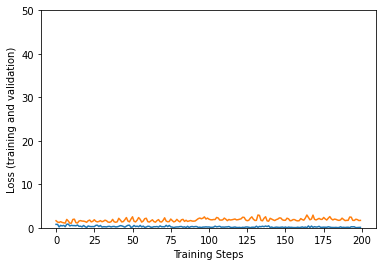

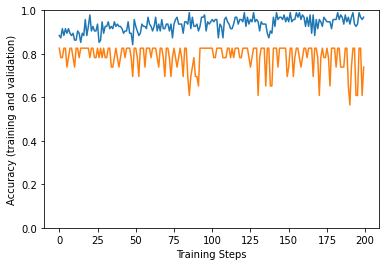

In [ ]:
plt.figure()
plt.ylabel('Loss (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,50])
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.figure()
plt.ylabel('Accuracy (training and validation)')
plt.xlabel('Training Steps')
plt.ylim([0,1])
plt.plot(hist['acc'])
plt.plot(hist['val_acc'])
# orange line is for validation accuracy and blue is for training accuracy

In [ ]:
# Get images and labels batch from validation dataset generator

val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)

print('Validation batch shape:', val_image_batch.shape)

Validation batch shape: (23, 224, 224, 3)


In [ ]:
tf_model_predictions = model(val_image_batch)
print('Prediction results shape:', tf_model_predictions.shape)

Prediction results shape: (23, 2)
